In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


# Comparison of kernel ridge regression and SVR

Both kernel ridge regression (KRR) and SVR learn a non-linear function by
employing the kernel trick, i.e., they learn a linear function in the space
induced by the respective kernel which corresponds to a non-linear function in
the original space. They differ in the loss functions (ridge versus
epsilon-insensitive loss). In contrast to SVR, fitting a KRR can be done in
closed-form and is typically faster for medium-sized datasets. On the other
hand, the learned model is non-sparse and thus slower than SVR at
prediction-time.

This example illustrates both methods on an artificial dataset, which
consists of a sinusoidal target function and strong noise added to every fifth
datapoint.


Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
License: BSD 3 clause



## Generate sample data



In [2]:
import numpy as np

rng = np.random.RandomState(42)

X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

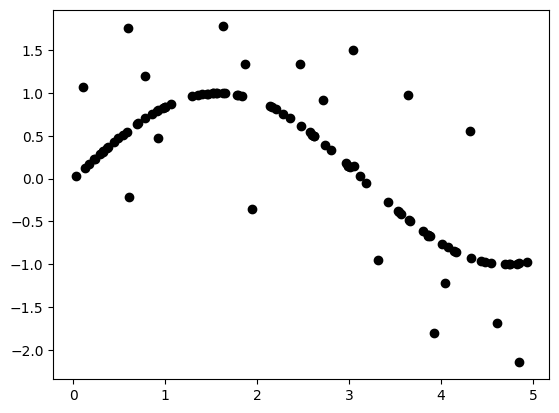

In [3]:
plt.scatter(X[:100], y[:100], c="k", label="data", zorder=1, edgecolors=(0, 0, 0))

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

### Q1
from sklearn.metrics import X_score

Find the score that is most useful for regression

In [5]:
train_size = 100

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score

Linear Regression R2 score:  0.5037640356741457


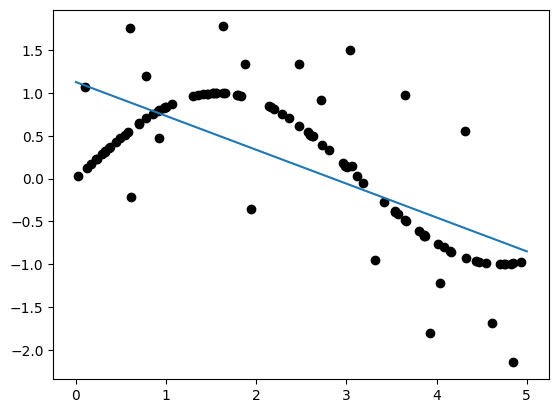

In [7]:
# Lets try a simple linear regression.
reg = LinearRegression(fit_intercept=True).fit(X[:train_size],y[:train_size])
y_reg = reg.predict(X_plot)

plt.scatter(X[:100], y[:100], c="k", label="data", zorder=1, edgecolors=(0, 0, 0))
plt.plot(X_plot,y_reg)
print("Linear Regression R2 score: ", r2_score(y[:train_size],reg.predict(X[:train_size])))

### Q2
Clearly linear regression (with or wihout regularization) wont work. Let us try Kernel regression which would use higher order polynomials to fit to the data.
Recall that kernel trick is to define a "kernel" and then update a paramemter $\beta$. 
Here is the update rule, instead of updating $\theta$ (0...n) we will upate $\beta$ (0..m).
Please note that in the new notes (m, n) are replaced by (n, d) that is the number of samples is $n$ and number of features is $d$. 
![Image](kernelUpdate.png)
Steps for kernel regression
1. Define a kernel -- use from sklearn.metrics.pairwise import pairwise_kernels -- what kernel is best?
2. Code update step above.
3. Code the predict function

In [8]:
from sklearn.metrics.pairwise import pairwise_kernels

In [9]:
help(pairwise_kernels)

Help on function pairwise_kernels in module sklearn.metrics.pairwise:

pairwise_kernels(X, Y=None, metric='linear', *, filter_params=False, n_jobs=None, **kwds)
    Compute the kernel between arrays X and optional array Y.
    
    This method takes either a vector array or a kernel matrix, and returns
    a kernel matrix. If the input is a vector array, the kernels are
    computed. If the input is a kernel matrix, it is returned instead.
    
    This method provides a safe way to take a kernel matrix as input, while
    preserving compatibility with many other algorithms that take a vector
    array.
    
    If Y is given (default is None), then the returned matrix is the pairwise
    kernel between the arrays from both X and Y.
    
    Valid values for metric are:
        ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf',
        'laplacian', 'sigmoid', 'cosine']
    
    Read more in the :ref:`User Guide <metrics>`.
    
    Parameters
    ----------
    X : ndarra

In [10]:
# define metric, and then get the kernel
metric = 'rbf'
kernel_train = pairwise_kernels(X[:train_size], X[:train_size], metric=metric)

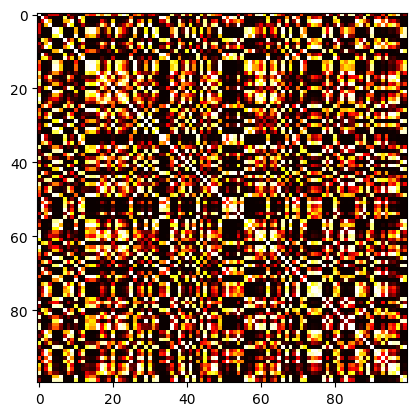

In [11]:
# Heat map 
plt.imshow(kernel_train, cmap='hot', interpolation='nearest')

In [12]:
beta = np.zeros((train_size,1))
alpha = 0.005
for iter in range(train_size):
    beta += alpha*(y[:train_size, np.newaxis] - np.matmul(kernel_train,beta))
    print(np.mean(np.abs(y[:train_size, np.newaxis] - np.matmul(kernel_train,beta))))

0.6579485748745442
0.5864906960484184
0.5261726304659947
0.47526121794842674
0.43246007020537236
0.3975523959008007
0.3681861311472726
0.34292361749951344
0.3214423649749558
0.30325419655777414
0.28749951643099
0.273794925774703
0.261872159969581
0.2514804429256867
0.2424104474331037
0.23469343115609514
0.2284558587940013
0.22297022006170386
0.21826950525179672
0.21413475200361995
0.21058054964285947
0.2074496241650344
0.20470002985043148
0.2022882722051129
0.20052033869344396
0.19929315885942675
0.19823971654142164
0.19745286745862545
0.19682370927650916
0.19636304426829093
0.1960134741219639
0.1957063408936005
0.19541083872235354
0.1951258998150012
0.19488154712413738
0.19471850283578346
0.19457538998897025
0.19456247884471697
0.1945984298117448
0.1946390927237107
0.19467055225655863
0.19469275915399148
0.19475775416982546
0.19485651264566056
0.19502200471330858
0.19518890126898428
0.19534977924708583
0.19551064570041102
0.19566615181929037
0.19580832761470301
0.1959418745767116
0.19

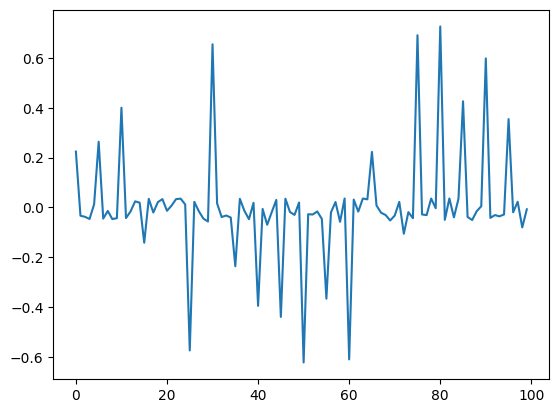

In [13]:
# plot beta
plt.plot(beta)

In [14]:
def kernel_ridge_update(X, y, train_size, alpha=0.5):
    
    n = X.shape[0]
    
    beta = np.zeros(n)

    for _ in range(train_size):
        beta = beta + alpha * (y - X @ beta)

    return beta

In [15]:
# Predict function
def predict(X_plot, X, beta, metric):
    n = beta.shape[0]
    kernel_plot = pairwise_kernels(X_plot, X, metric=metric)
    y_pred = np.zeros((n,1))
    y_pred = kernel_plot @ beta
    # for i in range(n):
    #     y_pred[i] = np.sum(kernel_plot * beta[i])
    return y_pred

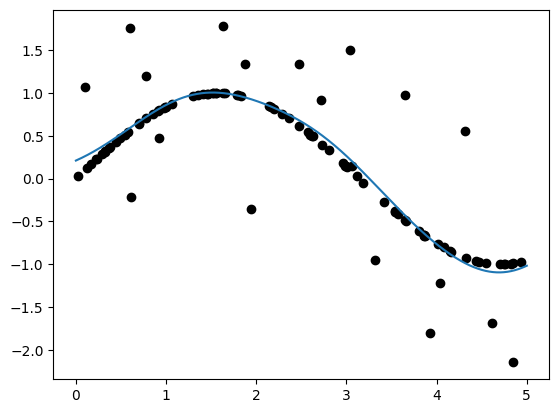

In [16]:
y_kernel_reg = predict(X_plot,X[:train_size],beta,metric)
plt.scatter(X[:100], y[:100], c="k", label="data", zorder=1, edgecolors=(0, 0, 0))
plt.plot(X_plot,y_kernel_reg)

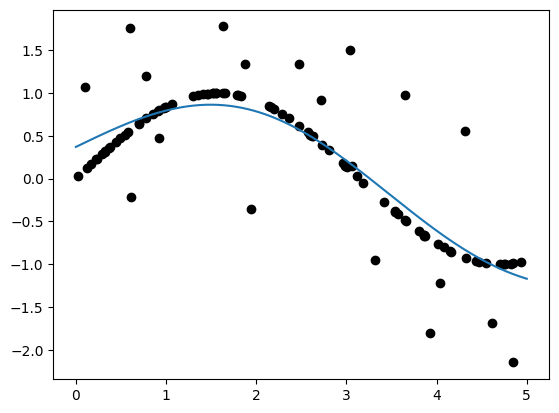

In [17]:
#another way of doing kernel regression is to use sklearn
kreg = KernelRidge(kernel="rbf", gamma=0.1)
kreg.fit(X[:train_size], y[:train_size])
y_kreg_predict = kreg.predict(X_plot)
plt.scatter(X[:100], y[:100], c="k", label="data", zorder=1, edgecolors=(0, 0, 0))
plt.plot(X_plot,y_kreg_predict)

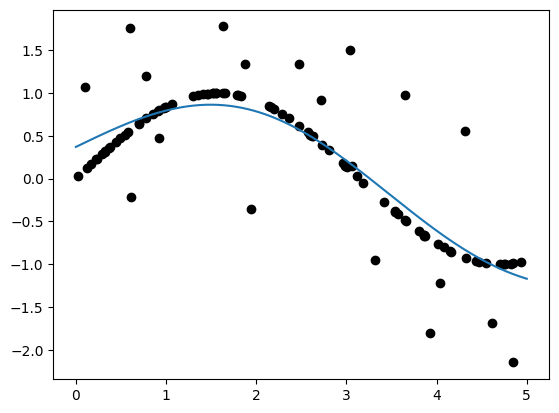

In [18]:
# similarly you can use SVM Regression to regress on above data
sreg = SVR(kernel="rbf", gamma=0.1)
sreg.fit(X[:train_size], y[:train_size])
s_kreg_predict = kreg.predict(X_plot)
plt.scatter(X[:100], y[:100], c="k", label="data", zorder=1, edgecolors=(0, 0, 0))
plt.plot(X_plot,s_kreg_predict)

### Q3 What is the difference between SVR and KernelRidge?

1. The primary difference between SVR and kernel regression is the use of the error margin in the minimization function.

2. By utilising an epsilon error margin, SVR allows for some amount of inaccuracy in the training data, which can assist prevent overfitting and enhance the model's generalisation performance.

3. The other difference is that SVR uses a loss function that is not differentiable everywhere, while KRR uses a loss function that is differentiable everywhere. This makes KRR easier to optimize, but at the same time makes it more sensitive to numerical errors.


### Q4 For kernelRidge and SVR there are few parameters to choose from  -- metric, gamma, alpha. Use GridSearchCV to search for the best parameters.


In [19]:
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
 |  
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "score_samples", "predict", "predict_proba",
 |  "decision_function", "transform" and "inverse_transform" if they are
 |  implemented in the estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either est

## Construct the kernel-based regression models



In [20]:
svr = GridSearchCV(
    SVR(kernel='rbf', gamma=0.1), 
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
)
kr = GridSearchCV(
    KernelRidge(kernel='rbf', gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

## Compare times of SVR and Kernel Ridge Regression



In [21]:
import time

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print(f"Best SVR with params: {svr.best_params_} and R2 score: {svr.best_score_:.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print(f"Best KRR with params: {kr.best_params_} and R2 score: {kr.best_score_:.3f}")
print("KRR complexity and bandwidth selected and model fitted in %.3f s" % kr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)



t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s" % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s" % (X_plot.shape[0], kr_predict))

Best SVR with params: {'C': 1.0, 'gamma': 0.1} and R2 score: 0.737
SVR complexity and bandwidth selected and model fitted in 1.021 s
Best KRR with params: {'alpha': 0.1, 'gamma': 0.1} and R2 score: 0.723
KRR complexity and bandwidth selected and model fitted in 0.261 s
Support vector ratio: 0.340
SVR prediction for 100000 inputs in 0.624 s
KRR prediction for 100000 inputs in 0.276 s


## Look at the results



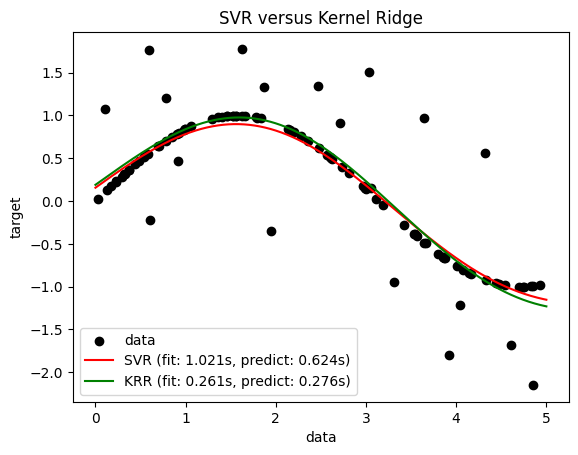

In [22]:
import matplotlib.pyplot as plt

sv_ind = svr.best_estimator_.support_
# plt.scatter(
#     X[sv_ind],
#     y[sv_ind],
#     c="r",
#     s=50,
#     label="SVR support vectors",
#     zorder=2,
#     edgecolors=(0, 0, 0),
# )
plt.scatter(X[:100], y[:100], c="k", label="data", zorder=1, edgecolors=(0, 0, 0))
plt.plot(
    X_plot,
    y_svr,
    c="r",
    label="SVR (fit: %.3fs, predict: %.3fs)" % (svr_fit, svr_predict),
)
plt.plot(
    X_plot, y_kr, c="g", label="KRR (fit: %.3fs, predict: %.3fs)" % (kr_fit, kr_predict)
)


plt.xlabel("data")
plt.ylabel("target")
plt.title("SVR versus Kernel Ridge")
_ = plt.legend()

The previous figure compares the learned model of KRR and SVR when both
complexity/regularization and bandwidth of the RBF kernel are optimized using
grid-search. The learned functions are very similar; however, fitting KRR is
approximatively 3-4 times faster than fitting SVR (both with grid-search).

Prediction of 100000 target values could be in theory approximately three
times faster with SVR since it has learned a sparse model using only
approximately 1/3 of the training datapoints as support vectors. However, in
practice, this is not necessarily the case because of implementation details
in the way the kernel function is computed for each model that can make the
KRR model as fast or even faster despite computing more arithmetic
operations.



## Visualize training and prediction times



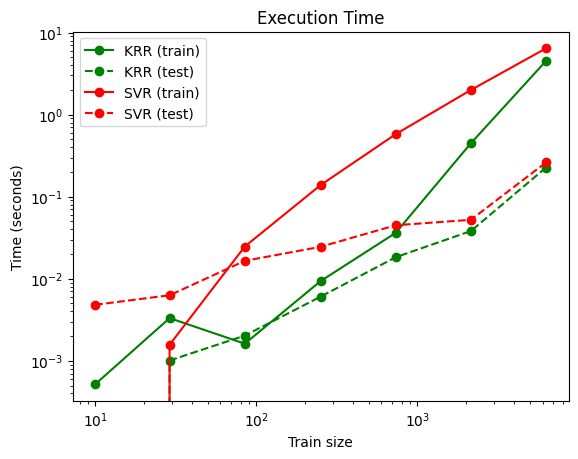

In [23]:
plt.figure()

sizes = np.logspace(1, 3.8, 7).astype(int)
for name, estimator in {
    "KRR": KernelRidge(kernel="rbf", alpha=0.01, gamma=10),
    "SVR": SVR(kernel="rbf", C=1e2, gamma=10),
}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(
        sizes,
        train_time,
        "o-",
        color="r" if name == "SVR" else "g",
        label="%s (train)" % name,
    )
    plt.plot(
        sizes,
        test_time,
        "o--",
        color="r" if name == "SVR" else "g",
        label="%s (test)" % name,
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title("Execution Time")
_ = plt.legend(loc="best")

This figure compares the time for fitting and prediction of KRR and SVR for
different sizes of the training set. Fitting KRR is faster than SVR for
medium-sized training sets (less than a few thousand samples); however, for
larger training sets SVR scales better. With regard to prediction time, SVR
should be faster than KRR for all sizes of the training set because of the
learned sparse solution, however this is not necessarily the case in practice
because of implementation details. Note that the degree of sparsity and thus
the prediction time depends on the parameters epsilon and C of the SVR.



## Visualize the learning curves



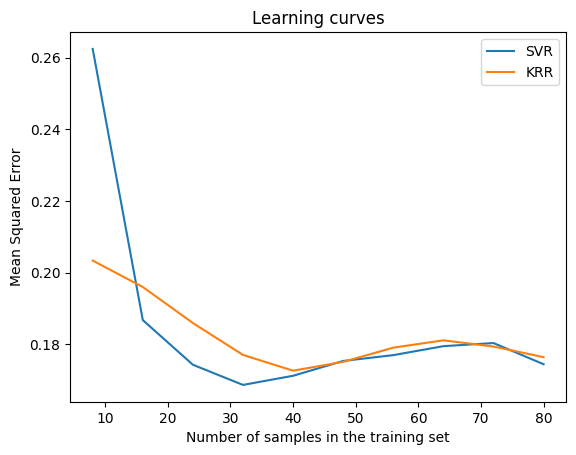

In [24]:
from sklearn.model_selection import LearningCurveDisplay

_, ax = plt.subplots()

svr = SVR(kernel="rbf", C=1e1, gamma=0.1)
kr = KernelRidge(kernel="rbf", alpha=0.1, gamma=0.1)

common_params = {
    "X": X[:100],
    "y": y[:100],
    "train_sizes": np.linspace(0.1, 1, 10),
    "scoring": "neg_mean_squared_error",
    "negate_score": True,
    "score_name": "Mean Squared Error",
    "std_display_style": None,
    "ax": ax,
}

LearningCurveDisplay.from_estimator(svr, **common_params)
LearningCurveDisplay.from_estimator(kr, **common_params)
ax.set_title("Learning curves")
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=["SVR", "KRR"])

plt.show()